In [1]:
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [ ]:
import os
import sys
from pathlib import Path
DIR_PATH = str(Path(os.getcwd()).parent.parent)
sys.path.append(DIR_PATH)

import merlin
from merlin.tools import TensorBoardCallback, WandModel, summary

# 数据准备

In [3]:
import torchvision
from torchvision import transforms

transform = transforms.Compose([transforms.ToTensor()])
ds_train = torchvision.datasets.MNIST(root=DIR_PATH +"/merlin/assets/data/mnist/", train=True, download=True, transform=transform)
ds_train = torch.utils.data.Subset(ds_train, range(0, len(ds_train), 20))
ds_val = torchvision.datasets.MNIST(root=DIR_PATH +"/merlin/assets/data/mnist/", train=False, download=True, transform=transform)
ds_val = torch.utils.data.Subset(ds_val, range(0, len(ds_train), 20))

dl_train = DataLoader(ds_train, batch_size=128, shuffle=True, num_workers=2)
dl_val = DataLoader(ds_val, batch_size=128, shuffle=True, num_workers=2)

In [4]:
for features, labels in dl_train:
    break

print(features.shape)
print(labels.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128])


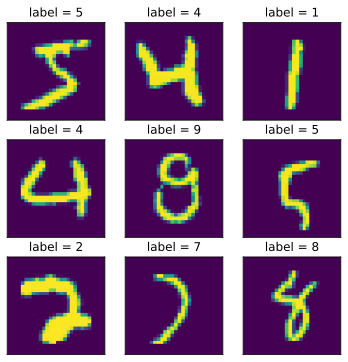

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#查看部分样本
from matplotlib import pyplot as plt 

fig = plt.figure(figsize=(6,6)) 
for i in range(9):
    img,label = ds_train[i]
    img = img.permute(1,2,0)
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()

# 模型定义

In [6]:
def create_net():
    net = nn.Sequential()
    net.add_module("conv1",nn.Conv2d(in_channels=1,out_channels=32,kernel_size = 3))
    net.add_module("pool1",nn.MaxPool2d(kernel_size = 2,stride = 2))
    net.add_module("conv2",nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5))
    net.add_module("pool2",nn.MaxPool2d(kernel_size = 2,stride = 2))
    net.add_module("dropout",nn.Dropout2d(p = 0.1))
    net.add_module("adaptive_pool",nn.AdaptiveMaxPool2d((1,1)))
    net.add_module("flatten",nn.Flatten())
    net.add_module("linear1",nn.Linear(64,32))
    net.add_module("relu",nn.ReLU())
    net.add_module("linear2",nn.Linear(32,10))
    return net

class Accuracy(nn.Module):
    def __init__(self):
        super().__init__()

        self.correct = nn.Parameter(torch.tensor(0.0),requires_grad=False)
        self.total = nn.Parameter(torch.tensor(0.0),requires_grad=False)

    def forward(self, preds: torch.Tensor, targets: torch.Tensor):
        preds = preds.argmax(dim=-1)
        m = (preds == targets).sum()
        n = targets.shape[0] 
        self.correct += m 
        self.total += n
        
        return m/n

    def compute(self):
        return self.correct.float() / self.total 
    
    def reset(self):
        self.correct -= self.correct
        self.total -= self.total

In [7]:
net = create_net()

model = WandModel(net,
  loss_fn = nn.CrossEntropyLoss(),
  optimizer= torch.optim.Adam(net.parameters(),lr=5e-3),
  metrics_dict = {"acc":Accuracy()}
)

In [8]:
summary_output = summary(model, input_data=features)

print("模型结构总结：")
print(summary_output)

--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Conv2d-1                            [-1, 32, 26, 26]                  320
MaxPool2d-2                         [-1, 32, 13, 13]                    0
Conv2d-3                              [-1, 64, 9, 9]               51,264
MaxPool2d-4                           [-1, 64, 4, 4]                    0
Dropout2d-5                           [-1, 64, 4, 4]                    0
AdaptiveMaxPool2d-6                   [-1, 64, 1, 1]                    0
Flatten-7                                   [-1, 64]                    0
Linear-8                                    [-1, 32]                2,080
ReLU-9                                      [-1, 32]                    0
Linear-10                                   [-1, 10]                  330
Total params: 53,994
Trainable params: 53,994
Non-trainable params: 0
-----------------------------------------

# 模型训练

<<<<<< 🐌 mps is used >>>>>>


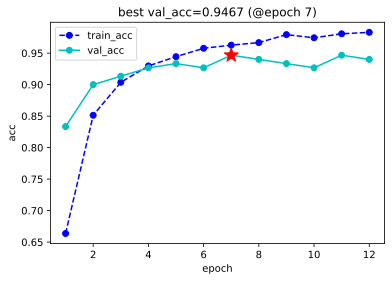

Early stopping at epoch 12. Best val_acc: 0.9466666579246521 at epoch 7


In [10]:
dfhistory = model.fit(
    train_data=dl_train,
    val_data=dl_val,
    epochs=15,
    patience=5,
    monitor="val_acc",
    mode="max",
    ckpt_path=DIR_PATH + "/merlin/assets/checkpoints/tools_01_wandmodel.ckpt",
    callbacks=[
        TensorBoardCallback(
            save_dir=DIR_PATH+"/merlin/assets/runs/tools_01_wandmodel",
            model_name="mnist_wandmodel_cnn",
            log_weight=True,
            log_weight_freq=5
        )
    ]
)

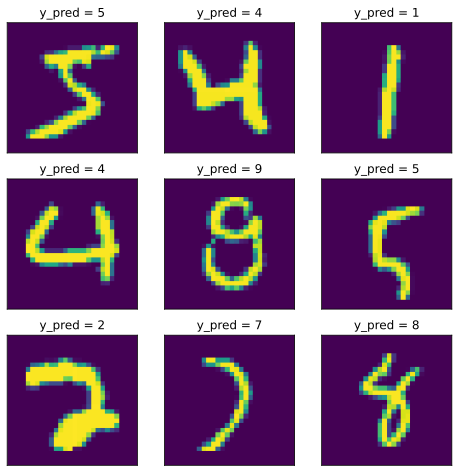

In [11]:
# visual the  prediction
device = None
for p in model.parameters():
    device = p.device
    break

plt.figure(figsize=(8,8)) 
for i in range(9):
    img,label = ds_train[i]
    tensor = img.to(device)
    y_pred = torch.argmax(net(tensor[None,...])) 
    img = img.permute(1,2,0)
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("y_pred = %d"%y_pred)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()

# TensorBoard 查看

In [12]:
from tensorboard import notebook
notebook.list() 

No known TensorBoard instances running.


In [ ]:
# !tensorboard --logdir="../merlin/assets/runs/tools_01_wandmodel"
notebook.start("--logdir ../merlin/assets/runs/tools_01_wandmodel")

Reusing TensorBoard on port 6006 (pid 52429), started 0:00:14 ago. (Use '!kill 52429' to kill it.)

# 模型评估

In [16]:
model.evaluate(dl_val)

  0%|                                                                         | 0/2 [00:00<?, ?it/s]

Traceback (most recent call last):
  File "<string>", line 1, in <module>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/anaconda3/envs/howl/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
  File "/opt/anaconda3/envs/howl/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
    exitcode = _main(fd, parent_sentinel)
                              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/opt/anaconda3/envs/howl/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
  File "/opt/anaconda3/envs/howl/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^    self = reduction.pickle.load(from_parent)
^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/howl/lib/python3.12/site-packages/torch/multiprocessing/reductions.py", line 560, in rebuild_storage_filename
           ^^^^^^^^^^^

  0%|                                                                         | 0/2 [00:02<?, ?it/s]


RuntimeError: DataLoader worker (pid(s) 52494) exited unexpectedly

In [17]:
import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory["train_"+metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

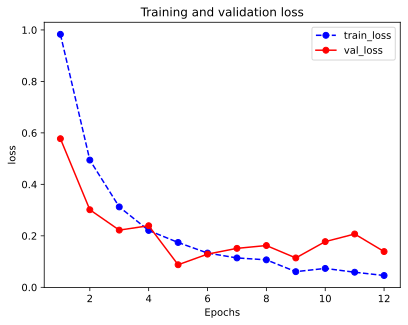

In [18]:
plot_metric(dfhistory,'loss')

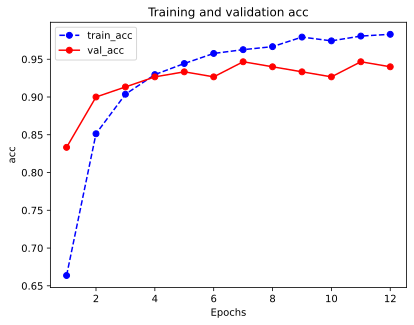

In [19]:
plot_metric(dfhistory,"acc")

# 模型使用

In [24]:
net = model.net
net.eval();

device = torch.device("cuda" if torch.cuda.is_available() else "mps")
img, label = ds_train[1]
tensor = img.to(device)

y_pred = torch.argmax(net(tensor[None,...])) 
y_prob = torch.softmax(net(tensor[None,...]),dim=-1).max() 

img = img.permute(1,2,0)
plt.imshow(img)
print('y_pred = ', y_pred.item())
print('y_prob = ', y_prob.item())

y_pred =  4
y_prob =  0.999916672706604


# 模型加载

In [26]:
#  used the saved model parameters 
net_clone = create_net() 

model_clone = merlin.WandModel(net_clone,loss_fn = nn.CrossEntropyLoss(),
             optimizer= torch.optim.Adam(net_clone.parameters(),lr = 0.001),
             metrics_dict={"acc":Accuracy()})

model_clone.load_ckpt(DIR_PATH + "/merlin/assets/checkpoints/tools_01_wandmodel.ckpt")